In [1]:
import numpy as np
from numpy import random
import matplotlib.pyplot as plt

In [2]:
# Parameters

b = 0.1  # phase lag parameter (beta) - default is 0.1
a = np.pi / 2 - b  # phase lag (alpha)

k = 0.35 # coupling parameter - default is 0.2
u = (1 - k) / 2  # inter-community coupling strength
v = 1 - u  # intra-community coupling strength

comm_size = 32 # community size
nc = 8  # number of communities
n_tot = comm_size * nc  # total number of oscillators

intra_n = 32 # number of intra-community connections
inter_n = 32  # number of inter-community connections

In [3]:
# Plotting


def plot_syncs(sync, t, T, ws):
  '''Plot synchrony over time for each community.'''
  print('Time step: {}'.format(t + 1))
  print()
  # Plot synchrony history
  plt.figure(figsize=(12, 3))
  plt.plot(ws * np.arange((T // ws)), sync, linewidth=1)
  plt.xlabel('Time')
  plt.ylabel('Synchrony')
  plt.xlim((0, T))
  plt.ylim((0, 1))
  plt.show()

def plot_syncs_individual(sync, T, ws, A):
  '''Plot synchrony over time for each community.'''
  # Plot synchrony history
  plt.figure(figsize=(6, 3))
  plt.plot(ws * np.arange((T // ws)), sync[:, A], linewidth=1)
  plt.xlabel('Time')
  plt.ylabel('Order Parameter')
  plt.xlim((0, T))
  plt.ylim((0, 1))
  plt.show()

def plot_phases(theta, t, comm_size, nc):
  '''Generate dial plots of phases in each community.'''
  prop_cycle = plt.rcParams['axes.prop_cycle']
  colours = prop_cycle.by_key()['color']
  plt.figure(figsize=(10, 2))
  for i in range(nc):
    plt.subplot(1, nc, i+1, aspect='equal')
    data = np.exp(theta[t, i * comm_size + 1:(i + 1) * comm_size] * 1j)
    plt.scatter(data.real, data.imag,
                marker='.', color=colours[i])
    plt.xlim((-1, 1))
    plt.ylim((-1, 1))
    plt.xticks([])
    plt.yticks([])
  plt.show()

In [4]:
def build_matrix(comm_size, nc, intra_n, inter_n, v, u):
  '''Build coupling matrix.'''
  n_tot = comm_size * nc  # total number of oscillators
  A = np.zeros((n_tot, n_tot))
  for i in range(n_tot):
    x1 = np.mod(np.ceil(i / comm_size) - 1, nc) + 1  # community number
    for j in range(i + 1, n_tot):
      if i != j:  # ignore diagonals
        y1 = np.mod(np.ceil(j / comm_size) - 1, nc) + 1  # community number
        if x1 == y1:  # same community
          p = intra_n / comm_size
          A = v
        else:  # different communities
          p = inter_n / (comm_size * nc)
          A = u
        if random.uniform() < p:
          A[i, j] = A
          A[j, i] = A
  return A

In [5]:
def kuramoto(theta, t, w, A, a, Dmean):
  '''Simulate the Kuramoto model using 4th-order Runge-Kutta method.'''
  h = 0.05  # step size
  hby2 = 0.5 * h
  temp1 = theta[t-1, :]
  for j in range(1, int(1 / h)):
    temp2 = temp1
    for i in range(n_tot):
      # Numerical simulation using 4th-order Runge-Kutta method
      rk1 = w[i] + np.dot(A[i], np.sin(temp2 - temp1[i] - a) / Dmean)
      rk2 = w[i] + np.dot(A[i], np.sin(temp2 - (temp1[i] + hby2 * rk1) - a) / Dmean)
      rk3 = w[i] + np.dot(A[i], np.sin(temp2 - (temp1[i] + hby2 * rk2) - a) / Dmean)
      rk4 = w[i] + np.dot(A[i], np.sin(temp2 - (temp1[i] + h * rk3) - a) / Dmean)
      temp1[i] += h * (rk1 + 2 * rk2 + 2 * rk3 + rk4) / 6
  theta[t, :] = temp1
  return theta


def get_stats(sync, ws):
  '''Calculate metastability and chimera index.'''
  sync2 = sync[2000 // ws:]  # ignore first 200 time steps
  lmbda = np.mean(np.var(np.transpose(sync2), axis=-1))
  chi = np.mean(np.var(sync2, axis=-1))
  phi = np.mean(sync2)
  return (sync2, lmbda, chi, phi)


def main():

  # Set up
  w = np.ones(n_tot)  # identical natural frequencies
  t_tot = 3000  # number of time steps
  ws = 2  # window size for downsampling synchrony data - default is 2
  theta = np.zeros((t_tot, n_tot))  # oscillator phases
  theta[0] = random.uniform(size=n_tot) * 2 * np.pi - np.pi  # random initial phases
  Dmean = intra_n + inter_n  # average connections per oscillator
  phi = np.zeros((t_tot, nc))  # synchrony data
  tot_phi = np.zeros(nc)  # running total for synchrony over window
  sync = np.zeros((t_tot // ws, nc))  # downsampled synchrony data
  A = build_matrix(comm_size, nc, intra_n, inter_n, v, u)  # coupling matrix
  time_steps = []
  for t in range(1, t_tot):

    # Kuramoto model
    theta = kuramoto(theta, t, w, A, a, Dmean)
    # Normalise phases
    theta[t, :] = np.mod(theta[t, :] + np.pi, 2 * np.pi) - np.pi

    # Compute synchrony within communities
    theta2 = np.reshape(theta, (t_tot, nc, comm_size))[t]
    phi[t, :] = np.absolute(np.mean(np.exp(theta2 * 1j), axis=-1))
    time_steps = np.append(time_steps, t)
    # Running total synchronies in downsampling window
    if (t + 1) % ws == 0:
      tot_phi += phi[t, :]
      sync[t // ws, :] = tot_phi / ws  # average synchrony
      tot_phi = np.zeros(nc)
    else:
      tot_phi += phi[t, :]
    # Plotting
    if (t + 1) % 500 == 0:
      plot_syncs(sync, t, t_tot, ws)
      plot_phases(theta, t, comm_size, nc)

  # Display statistics for run
  (sync2, lmbda, chi, phi) = get_stats(sync, ws)
  for i in range(0, nc):
      plot_syncs_individual(sync2, t_tot - 2000, ws, i)
  print('Metastability = {:.3f}'.format(lmbda))
  print('Chimera index = {:.3f}'.format(chi))
  print('Mean synchrony = {:.3f}'.format(phi))

Time step: 500



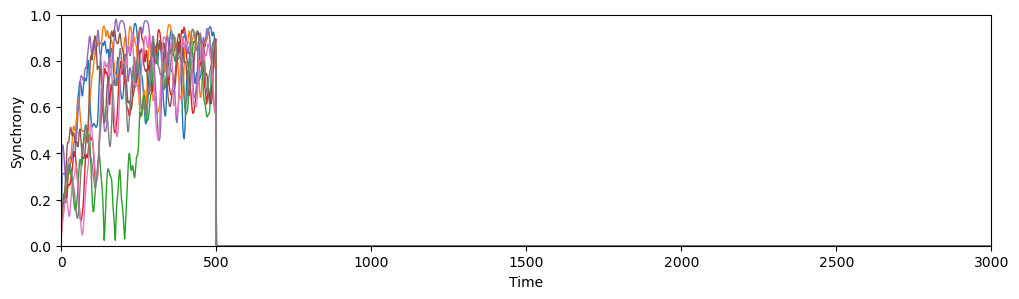

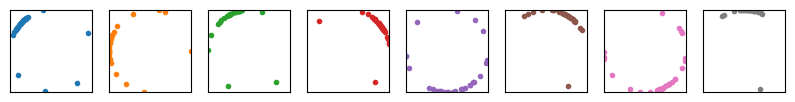

Time step: 1000



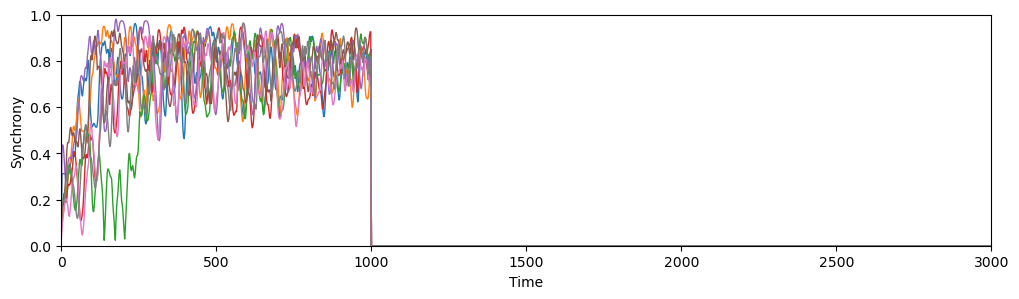

Time step: 1500



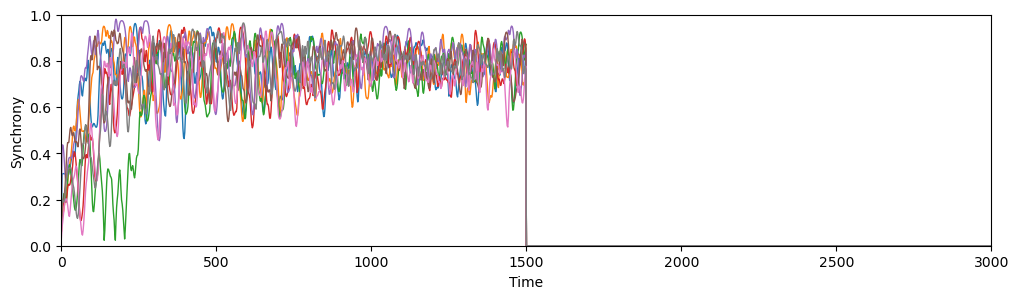

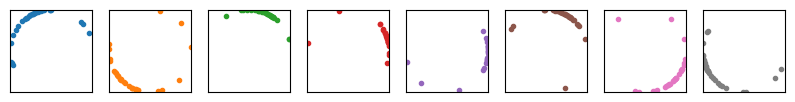

Time step: 2000



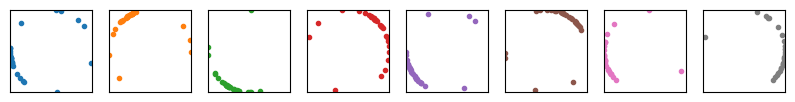

Time step: 2500



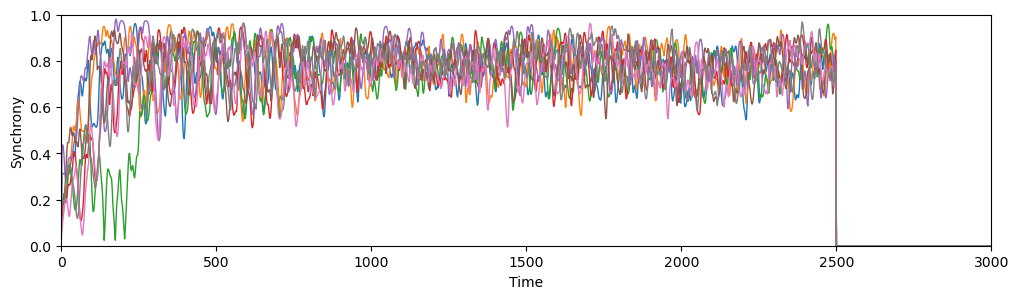

Time step: 3000



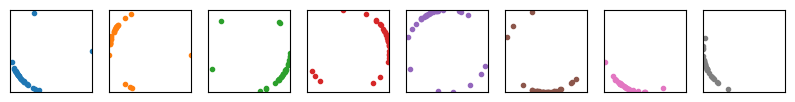

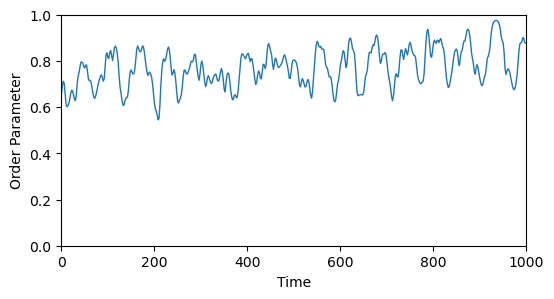

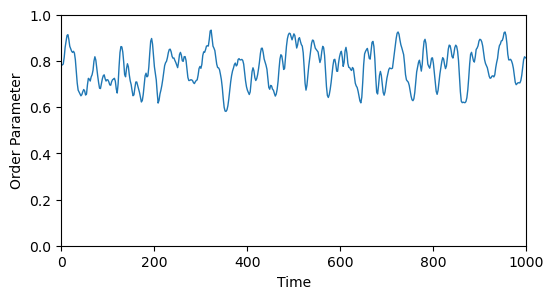

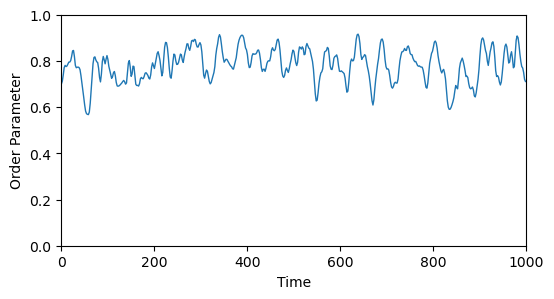

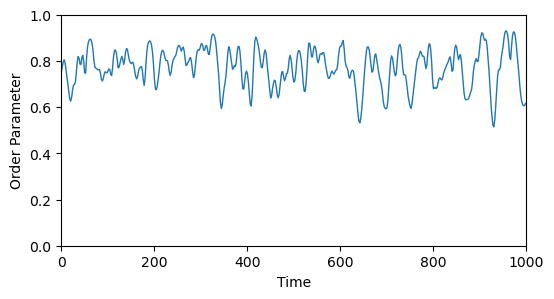

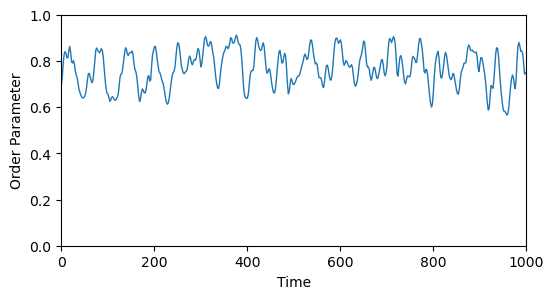

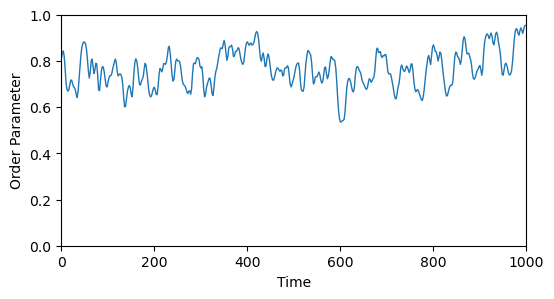

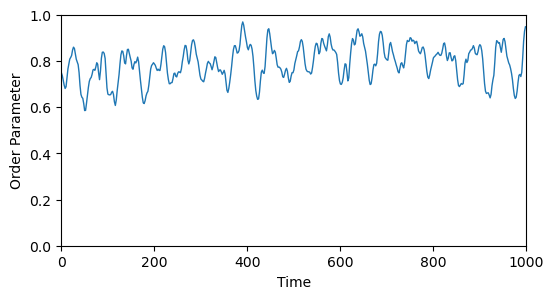

Metastability = 0.006
Chimera index = 0.005
Mean synchrony = 0.776


In [6]:
main()